# Generate multi-channel Features

In [191]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Load dataset
data = 'D' # ****** specify dataset (A / B / C / D) ******
dataset = pd.read_csv(f'./data/data_{data}.csv')
dataset_name='dataSet'+data

## Generate sliding window features 

In [129]:
# Generate features
all_windows=[]
min_window = 2 # minimum window size
max_window = 5 # maximum window size
for window_size in range(min_window,max_window+1):
    step=1
    ranges = [range(2)]*window_size
    windows=[]
    for xs in itertools.product(*ranges):
        windows.append([*xs])
    all_windows.append(windows)
    print(f'generating features with window size {window_size}...')
    for window in windows:
        sliding_activation=[]
        for line_n in range(len(dataset)):
            line = list(dataset.iloc[line_n,:])
            region_activation = []
            for start in range(32-window_size):
                region = list(dataset.iloc[:,1:-1].iloc[line_n,start:start+window_size])
                if region == window:
                    region_activation.append(1)
                else:
                    region_activation.append(0)
                start+=step
            sliding_activation.append(region_activation)
        pd.DataFrame(sliding_activation).to_csv(f'./features/window_size_{window_size}_window_{window}_dataset_{data}.csv',index=False)

generating features with window size 2...
generating features with window size 3...
generating features with window size 4...
generating features with window size 5...


In [130]:
# Combine features
print(f'combining features ...')

for i, window_size in enumerate(range(min_window,max_window+1)):
    windows = all_windows[i]
    df_all = []
    for col in range(32-window_size):
        all_column=[]
        for window in windows:
            column = list(pd.read_csv(f'./features/window_size_{window_size}_window_{window}_dataset_{data}.csv').iloc[:,col])
            all_column.append(column)
        df_all.append(list(zip(*all_column)))
    
    #save data
    transpose_m = np.transpose(np.array(df_all),(1,0,2))
    df_save = np.reshape(transpose_m,(len(transpose_m), -1))
    np.savetxt(f"./features/sliding_window_{window_size}_dataset_{data}.txt",df_save)
print('done')

combining features ...
done


# Multi-channel PolyConvNet

In [192]:
from keras import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Flatten, Concatenate, Input

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [193]:
#load kernels
kernel_matrix=[]
kernels = open(f'./features/{dataset_name}.kern').readlines()
for i in range(len(kernels)):
    kernel = [float(i) for i in kernels[i].strip().split()]
    kernel_matrix.append(kernel)

#load data
window_size = 2 # ****** specify window size ******

n_channel = 2**window_size

X = np.loadtxt(f"./features/sliding_window_{window_size}_dataset_{data}.txt")
X = X.reshape(X.shape[0], X.shape[1] // n_channel , n_channel)
interaction_param, y = dataset['interaction_parameter'], dataset['lamellar_period']

In [194]:
# train/test split
train_idx = np.random.choice(range(len(X)), size=int(0.8*(len(X))), replace=False)
X_train = X[train_idx]
y_train = np.array([y[i] for i in train_idx])

test_idx = list(set(range(len(X)))-set(train_idx))
X_test = X[test_idx]
y_test = np.array([y[i] for i in test_idx])

# auxInput
interaction_kernel_train = np.array([[interaction_param[i]]+kernel_matrix[i] for i in train_idx])
interaction_kernel_test = np.array([[interaction_param[i]]+kernel_matrix[i] for i in test_idx])

In [195]:
input_b = Input(shape=(46))

input = Input(shape =(32-window_size,n_channel)) 

x = Conv1D(32-window_size, 2, activation="relu", input_shape=(32-window_size,n_channel))(input)
x = Flatten()(x)

x = Concatenate()([x,input_b])
x = Flatten()(x)

x = Dense(units = 300, activation ='relu')(x)
x = Dense(units = 110, activation ='relu')(x)

regression = Dense(units = 1, activation='relu', name='regression')(x)

model = Model(inputs=[input,input_b], outputs=regression)

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse'])
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 30, 4)]      0           []                               
                                                                                                  
 conv1d_20 (Conv1D)             (None, 29, 30)       270         ['input_42[0][0]']               
                                                                                                  
 flatten_40 (Flatten)           (None, 870)          0           ['conv1d_20[0][0]']              
                                                                                                  
 input_41 (InputLayer)          [(None, 46)]         0           []                               
                                                                                           

/lus/theta-fs0/software/thetagpu/conda/2021-11-30/mconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [196]:
# model training
epochs = 500
history = model.fit([X_train, interaction_kernel_train], y_train, batch_size=12,epochs=epochs, verbose=1)

Epoch 1/500
75/75 [==============================] - 0s 2ms/step - loss: 21.7303 - mse: 21.7303
Epoch 2/500
75/75 [==============================] - 0s 2ms/step - loss: 0.3476 - mse: 0.3476
Epoch 3/500
75/75 [==============================] - 0s 2ms/step - loss: 0.1413 - mse: 0.1413
Epoch 4/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0652 - mse: 0.0652
Epoch 5/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0492 - mse: 0.0492
Epoch 6/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0343 - mse: 0.0343
Epoch 7/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0308 - mse: 0.0308
Epoch 8/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0268 - mse: 0.0268
Epoch 9/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0225 - mse: 0.0225
Epoch 10/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0235 - mse: 0.0235
Epoch 11/500
75/75 [==============================] - 0s 

75/75 [==============================] - 0s 1ms/step - loss: 0.0206 - mse: 0.0206
Epoch 88/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0263 - mse: 0.0263
Epoch 89/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0263 - mse: 0.0263
Epoch 90/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0226 - mse: 0.0226
Epoch 91/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0139 - mse: 0.0139
Epoch 92/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0179 - mse: 0.0179
Epoch 93/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0319 - mse: 0.0319
Epoch 94/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0345 - mse: 0.0345
Epoch 95/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0160 - mse: 0.0160
Epoch 96/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096
Epoch 97/500
75/75 [==============================] - 0s 2ms/st

75/75 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 173/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0109 - mse: 0.0109
Epoch 174/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0081 - mse: 0.0081
Epoch 175/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0135 - mse: 0.0135
Epoch 176/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 177/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0123 - mse: 0.0123
Epoch 178/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0108 - mse: 0.0108
Epoch 179/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 0.0050  
Epoch 180/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0079 - mse: 0.0079
Epoch 181/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 0.0089
Epoch 182/500
75/75 [==============================]

75/75 [==============================] - 0s 1ms/step - loss: 0.0055 - mse: 0.0055
Epoch 258/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0063 - mse: 0.0063
Epoch 259/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 0.0050
Epoch 260/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0046 - mse: 0.0046
Epoch 261/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0088 - mse: 0.0088
Epoch 262/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0146 - mse: 0.0146
Epoch 263/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0063 - mse: 0.0063
Epoch 264/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0055 - mse: 0.0055
Epoch 265/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0040 - mse: 0.0040
Epoch 266/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0049 - mse: 0.0049
Epoch 267/500
75/75 [==============================] -

75/75 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019
Epoch 343/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014  
Epoch 344/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027  
Epoch 345/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017
Epoch 346/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022  
Epoch 347/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054
Epoch 348/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018
Epoch 349/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 0.0022
Epoch 350/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0110 - mse: 0.0110
Epoch 351/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0152 - mse: 0.0152
Epoch 352/500
75/75 [===========================

75/75 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018
Epoch 428/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0040 - mse: 0.0040
Epoch 429/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 0.0018
Epoch 430/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0034 - mse: 0.0034  
Epoch 431/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017
Epoch 432/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020
Epoch 433/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0041 - mse: 0.0041
Epoch 434/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 435/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0048 - mse: 0.0048
Epoch 436/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0120 - mse: 0.0120
Epoch 437/500
75/75 [==============================]

In [197]:
# making prediction
ypred_test = model.predict([X_test, interaction_kernel_test])
model_mse = mean_squared_error(y_test, ypred_test)
print("MSE: %.4f" % model_mse)

MSE: 0.0128


In [198]:
# calc R2
correlation_matrix = np.corrcoef(ypred_test.flatten(), y_test)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

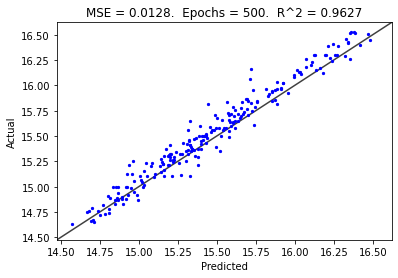

In [199]:
# plot result
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

plt.title(f'MSE = {model_mse:.4f}.  Epochs = {epochs}.  R^2 = {r_squared:.4f}') # MSE
plt.scatter(ypred_test, y_test, s=5, color="blue") # x_axis, y_axis, ...
plt.xlabel("Predicted")
plt.ylabel("Actual")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.savefig(f'pred_{data}')

In [200]:
#save model
model.save(f"multi_channel_polycovnet_{data}")

INFO:tensorflow:Assets written to: multi_channel_polycovnet_D/assets


INFO:tensorflow:Assets written to: multi_channel_polycovnet_D/assets
